## Disease Condition prediction based on drug reviews

In this project, we will classify the condition of patients using the reviews of the drugs given by patients using drug reviews dataset available in [UCI ML Repository](https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com).

## Importing libraries

In [1]:
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [2]:
df=pd.read_csv('drugsComTrain_raw.tsv',sep='\t')

In [3]:
# Assuming 'condition' is the column name in your DataFrame
counts = df['condition'].value_counts()

# Get index values where the count is less than 100
indexes_to_drop = counts[counts < 1000].index

# Drop rows based on the index values
df= df[~df['condition'].isin(indexes_to_drop)]

In [4]:
df.head()

Unnamed: 0                  drugName                condition  \
1       95260                Guanfacine                     ADHD   
2       92703                    Lybrel            Birth Control   
3      138000                Ortho Evra            Birth Control   
4       35696  Buprenorphine / naloxone        Opiate Dependence   
6      165907            Levonorgestrel  Emergency Contraception   

                                              review  rating  \
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   
6  "He pulled out, but he cummed a bit in me. I t...     1.0   

                date  usefulCount  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37  
6      March 7, 2017            5

In [5]:
df["condition"].nunique()

32

In [6]:
df_train = df

In [7]:
df.shape

(111020, 7)

In [8]:
df_train.shape

(111020, 7)

In [9]:
X = df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

In [10]:
X.shape

(111020, 2)

In [11]:
X.dropna(inplace=True)

## EDA

In [12]:
X.condition.value_counts()

condition
Birth Control                  28788
Depression                      9069
Pain                            6145
Anxiety                         5904
Acne                            5588
Bipolar Disorde                 4224
Insomnia                        3673
Weight Loss                     3609
Obesity                         3568
ADHD                            3383
Diabetes, Type 2                2554
Emergency Contraception         2463
High Blood Pressure             2321
Vaginal Yeast Infection         2274
Abnormal Uterine Bleeding       2096
Bowel Preparation               1859
ibromyalgia                     1791
Smoking Cessation               1780
Migraine                        1694
Anxiety and Stress              1663
Major Depressive Disorde        1607
Constipation                    1595
Panic Disorde                   1463
Chronic Pain                    1455
Migraine Prevention             1413
Urinary Tract Infection         1316
Muscle Spasm                

In [13]:
X.head()

condition                                             review
1                     ADHD  "My son is halfway through his fourth week of ...
2            Birth Control  "I used to take another oral contraceptive, wh...
3            Birth Control  "This is my first time using any form of birth...
4        Opiate Dependence  "Suboxone has completely turned my life around...
6  Emergency Contraception  "He pulled out, but he cummed a bit in me. I t...

In [14]:
# segregating dataframe for analyzing individual condition
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]

Text(0.5, 1.0, 'Word cloud for Birth control')

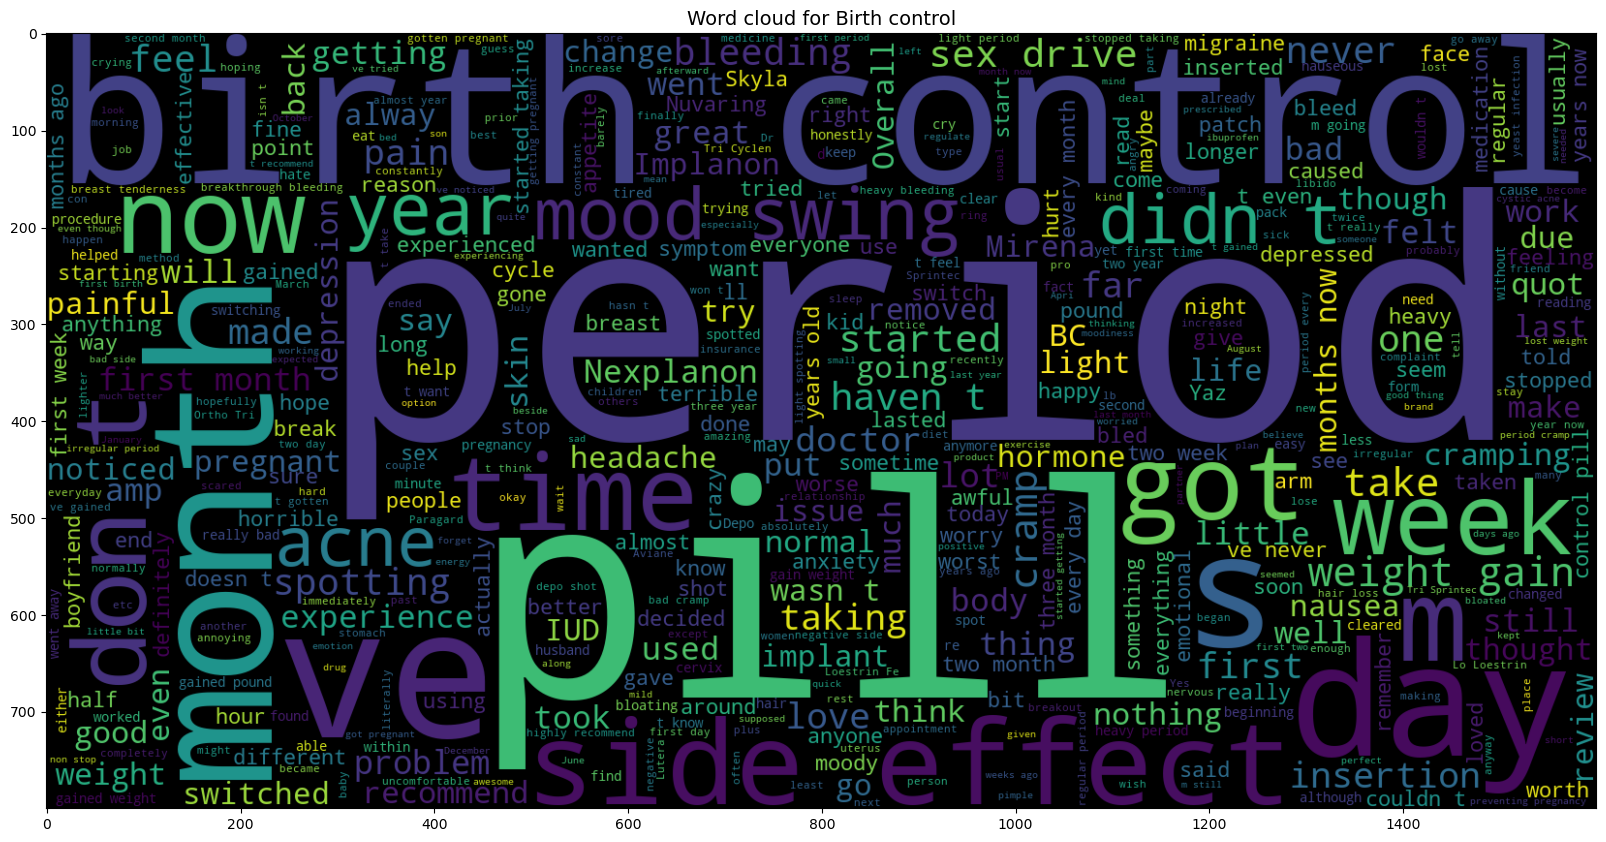

In [15]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_birth.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Birth control',fontsize=14)

In [17]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Depression')

Text(0.5, 1.0, 'Word cloud for High Blood Pressure')

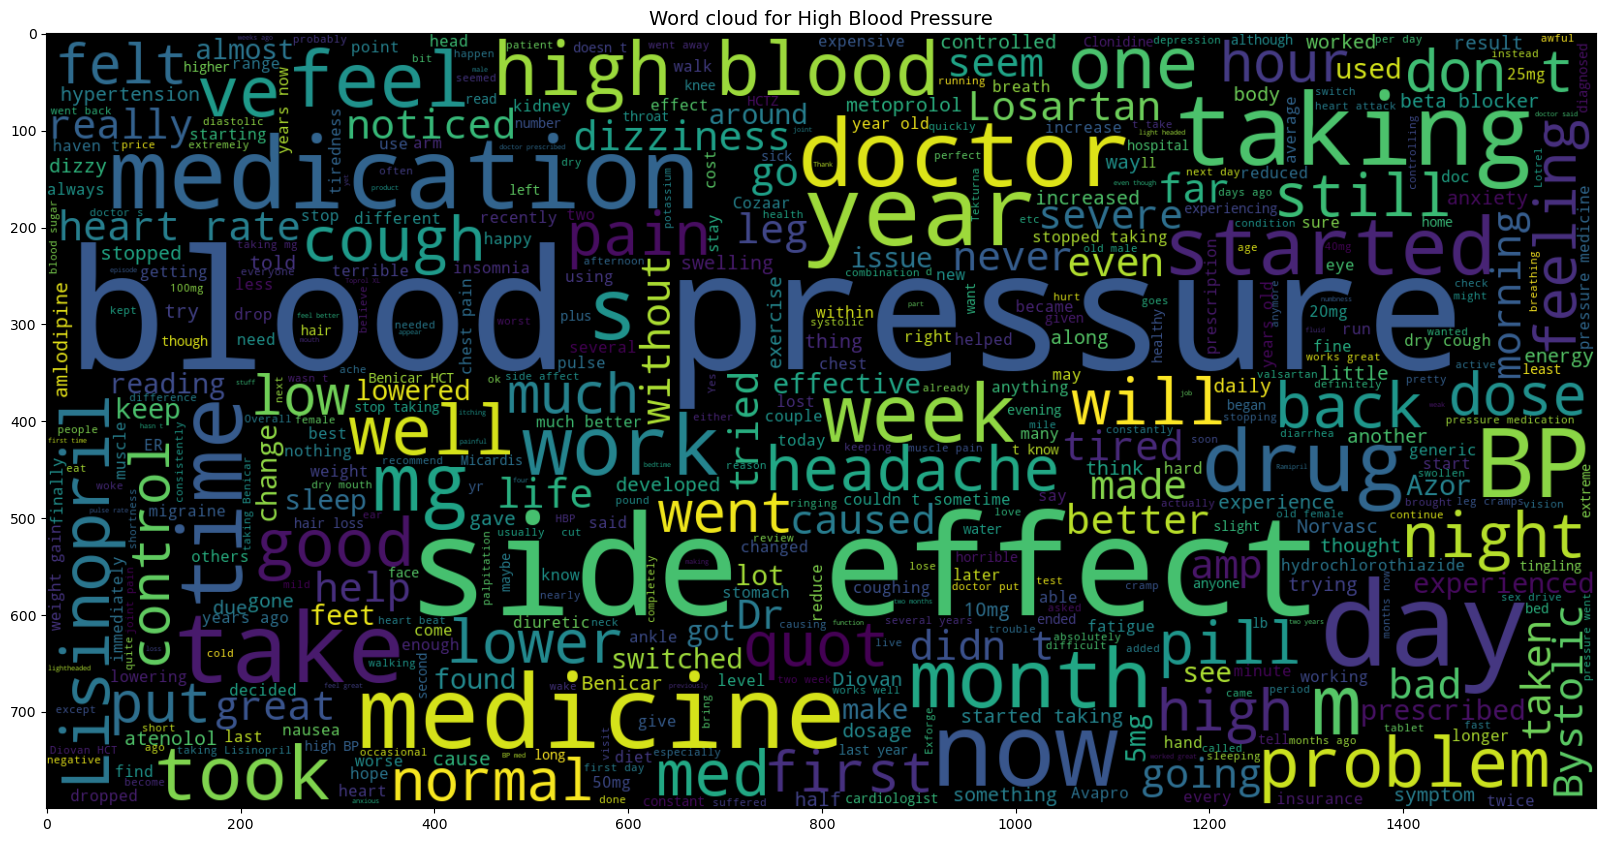

In [18]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_bp.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for High Blood Pressure',fontsize=14)

In [19]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_diab.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Diabetes Type 2',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Diabetes Type 2')

## data preprocessing

In [16]:
X['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [17]:
X['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [18]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [19]:
X.head()

condition                                             review
1                     ADHD  My son is halfway through his fourth week of I...
2            Birth Control  I used to take another oral contraceptive, whi...
3            Birth Control  This is my first time using any form of birth ...
4        Opiate Dependence  Suboxone has completely turned my life around....
6  Emergency Contraception  He pulled out, but he cummed a bit in me. I to...

### Stopwords 

In [20]:
from nltk.corpus import stopwords

stop = stopwords.words('english')


In [21]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Lemmitization

In [22]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

[nltk_data] Error loading wordnet: <urlopen error [Errno 54]
[nltk_data]     Connection reset by peer>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 54]
[nltk_data]     Connection reset by peer>


In [23]:
from bs4 import BeautifulSoup
import re

In [24]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [25]:
X['review_clean'] = X['review'].apply(review_to_words)

/var/folders/40/rltn7py91333t5f_9ztkmgkm0000gn/T/ipykernel_21909/2066199760.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [26]:
X.head()

condition                                             review  \
1                     ADHD  My son is halfway through his fourth week of I...   
2            Birth Control  I used to take another oral contraceptive, whi...   
3            Birth Control  This is my first time using any form of birth ...   
4        Opiate Dependence  Suboxone has completely turned my life around....   
6  Emergency Contraception  He pulled out, but he cummed a bit in me. I to...   

                                        review_clean  
1  son halfway fourth week intuniv became concern...  
2  used take another oral contraceptive pill cycl...  
3  first time using form birth control glad went ...  
4  suboxone completely turned life around feel he...  
6  pulled cummed bit took plan b hour later took ...

## Creating features and Target Variable

In [27]:
X_feat=X['review_clean']
y=X['condition']

In [28]:
y.dropna(inplace=True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Bag of Words

In [31]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [32]:
count_train

<88096x29356 sparse matrix of type '<class 'numpy.int64'>'
	with 2705969 stored elements in Compressed Sparse Row format>

## Machine Learning Model : Naive Bayes

In [33]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.763
Confusion matrix, without normalization


## Machine Learning Model : Passive Aggressive Classifier

In [33]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.976
Confusion matrix, without normalization


### Vectorization TF - IDF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Machine Learning Model : Naive Bayes

In [36]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.542
Confusion matrix, without normalization


## Machine Learning Model TF-IDF

In [37]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])


accuracy:   0.830
Confusion matrix, without normalization


## TF-IDF: Bigrams

In [38]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

In [39]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.875
Confusion matrix, without normalization


## TF-IDF : Trigrams

In [40]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

accuracy:   0.878
Confusion matrix, without normalization


## Most important Features

In [41]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names_out() 
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)



most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Birth Control')

Birth Control violated 0.7815910563891434
Birth Control sinking 0.8761157399950027
Birth Control sinus 0.8925859091921211
Birth Control accompany 0.9340102448217451
Birth Control kicker 0.958995451678665
Birth Control monastat 1.0306761149677999
Birth Control sooo 1.1446478533382924
Birth Control someway 1.5181024614623448
Birth Control sominex 1.5737866034312422
Birth Control emenlsy 1.6103685906401644


In [42]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

Depression gabbapentin 0.7527171722372451
Depression telogen 0.7883244304166929
Depression dip 0.8333817626401328
Depression diph 0.8333817626401328
Depression freeze 0.9402414353930223
Depression gave 0.9709708408752019
Depression gavilyte 0.9709708408752019
Depression appeti 0.9993436180396587
Depression appetie 0.9993436180396587
Depression ambulatory 1.680141008220643


In [43]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

High Blood Pressure lucozade 0.5691749484444897
High Blood Pressure lucrative 0.5691749484444897
High Blood Pressure metallically 0.5882086307245046
High Blood Pressure kicker 0.595016741413616
High Blood Pressure medispan 0.6203726000758834
High Blood Pressure broaden 0.7301938809639665
High Blood Pressure jitteriness 0.7451548000546133
High Blood Pressure jims 0.7685845671634656
High Blood Pressure broccoli 0.789251890653382
High Blood Pressure mileage 1.282863151323669


In [44]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

Diabetes, Type 2 doorknob 0.37135195169857554
Diabetes, Type 2 urination 0.39876078246130686
Diabetes, Type 2 suffered 0.44253749567919487
Diabetes, Type 2 suffereing 0.44253749567919487
Diabetes, Type 2 ahalf 0.4504391077195044
Diabetes, Type 2 accompany 0.4915556425367045
Diabetes, Type 2 bruise 0.5926713966592149
Diabetes, Type 2 mistoprostol 0.635858522819184
Diabetes, Type 2 usual 0.7060294740509472
Diabetes, Type 2 urethra 3.724792566393906


## Sample Predictions

In [45]:
X.tail()

condition  \
161284        Panic Disorde   
161286           Depression   
161287              Anxiety   
161290  High Blood Pressure   
161291        Birth Control   

                                                   review  \
161284  Had panic attacks and social anxiety starting ...   
161286  This is the third med I&#039;ve tried for anxi...   
161287  I was super against taking medication. I&#039;...   
161290  I have only been on Tekturna for 9 days. The e...   
161291  This would be my second month on Junel. I&#039...   

                                             review_clean  
161284  panic attack social anxiety starting adolescen...  
161286  third med tried anxiety mild depression week h...  
161287  super taking medication started dealing anxiet...  
161290  tekturna day effect immediate also calcium cha...  
161291  would second month junel birth control year ch...

In [48]:
text =["This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap."]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'Depression'

In [49]:
text =["I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me"]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'Diabetes, Type 2'

In [55]:
text =["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.",
    "This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.",
    "I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me",]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'High Blood Pressure'

In [56]:
## Function for Extracting Top drugs

def top_drugs_extractor(condition):
    df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating', 'usefulCount'], ascending = [False, False])
    drug_lst = df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
    return drug_lst

def predict_text(lst_text):
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])
    df_test["test_sent"] = df_test["test_sent"].apply(review_to_words)
    tfidf_bigram = tfidf_vectorizer3.transform(lst_text)
    prediction = pass_tf.predict(tfidf_bigram)
    df_test['prediction']=prediction
    return df_test

# sample sentences for recommending drugs
sentences = [
  "I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.",
    "This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.",
    "I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me",]


tfidf_trigram = tfidf_vectorizer.transform(sentences)


predictions = pass_tf.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label=="High Blood Pressure":
        target="High Blood Pressure"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Depression":
        target="Depression"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Diabetes, Type 2":
        target="Diabetes, Type 2"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    else:
        target="Birth Control"
        print("text:", text, "\Condition:", target)
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()

text: I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations. 
Condition: High Blood Pressure
Top 3 Suggested Drugs:
Losartan
Aldactone
Spironolactone

text: This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap. 
Condition: Depression
Top 3 Suggested Drugs:
Sertraline
Zoloft
Viibryd

text: I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losi